In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
class Processing:    
    def __init__(self):
        pass
    def filter_data(self, path):
        """
        Reads CSV into pandas DataFrame and drops redundant columns.
        """
        df = pd.read_csv(path, low_memory=False)

        drop_cols = [
            'isic_id',  # Redundant for loading train data
            'image_type',  # Only one unique value in train metadata
            'tbp_lv_location_simple',  # Similar to 'tbp_lv_location'
            'copyright_license',  # Not useful for lesion classification

            # Predictive Features
            'lesion_id',
            'iddx_full',
            'iddx_1', 
            'iddx_2', 
            'iddx_3',
            'iddx_4', 
            'iddx_5', 
            'mel_mitotic_index', 
            'mel_thick_mm',
        ]

        # Drop only columns that exist
        df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
        
        return df

    def set_datatypes(self, df: pd.DataFrame):
        """
        Converts column dtypes: handle NAs, cast numeric & categorical columns.
        """
        # Handle NA values in 'age_approx'
        if 'age_approx' in df.columns:
            df['age_approx'] = df['age_approx'].replace('NA', -1)

        # Integer columns
        int_cols = ['target', 'age_approx', 'tbp_lv_symm_2axis_angle']
        for col in int_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int16')

        # Float columns
        float_cols = [
            'clin_size_long_diam_mm',
            'tbp_lv_A', 
            'tbp_lv_Aext', 
            'tbp_lv_B', 
            'tbp_lv_Bext',
            'tbp_lv_C', 
            'tbp_lv_Cext', 
            'tbp_lv_H', 
            'tbp_lv_Hext', 
            'tbp_lv_L', 
            'tbp_lv_Lext',
            'tbp_lv_areaMM2', 
            'tbp_lv_area_perim_ratio', 
            'tbp_lv_color_std_mean',
            'tbp_lv_deltaA', 
            'tbp_lv_deltaB', 
            'tbp_lv_deltaL', 
            'tbp_lv_deltaLB',
            'tbp_lv_deltaLBnorm', 
            'tbp_lv_eccentricity', 
            'tbp_lv_minorAxisMM',
            'tbp_lv_nevi_confidence', 
            'tbp_lv_norm_border', 
            'tbp_lv_norm_color',
            'tbp_lv_perimeterMM', 
            'tbp_lv_radial_color_std_max', 
            'tbp_lv_stdL', 
            'tbp_lv_stdLExt',
            'tbp_lv_symm_2axis', 
            'tbp_lv_x', 
            'tbp_lv_y', 
            'tbp_lv_z'
        ]
        for col in float_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce').astype('float32')

        # Categorical columns
        cat_cols = [
            'sex', 
            'anatom_site_general', 
            'tbp_tile_type', 
            'tbp_lv_location', 
            'attribution'
        ]
        for col in cat_cols:
            if col in df.columns:
                df[col] = df[col].astype('category')

        return df

    def initial_processing(self, df: pd.DataFrame):
        """
        Applies full processing pipeline to the DataFrame.
        """
        df = self.filter_data(df)
        df = self.set_datatypes(df)
        return df

In [3]:
p = Processing()
df = p.initial_processing('subject_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 42 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   target                        401059 non-null  Int16   
 1   patient_id                    401059 non-null  object  
 2   age_approx                    398261 non-null  Int16   
 3   sex                           389542 non-null  category
 4   anatom_site_general           395303 non-null  category
 5   clin_size_long_diam_mm        401059 non-null  float32 
 6   tbp_tile_type                 401059 non-null  category
 7   tbp_lv_A                      401059 non-null  float32 
 8   tbp_lv_Aext                   401059 non-null  float32 
 9   tbp_lv_B                      401059 non-null  float32 
 10  tbp_lv_Bext                   401059 non-null  float32 
 11  tbp_lv_C                      401059 non-null  float32 
 12  tbp_lv_Cext                   

<Axes: ylabel='count'>

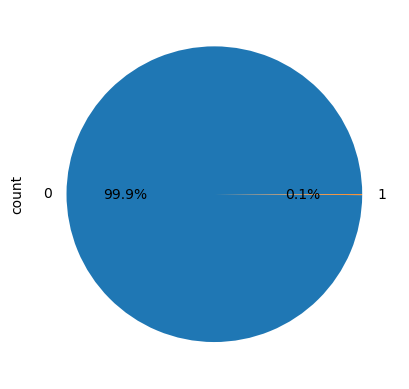

In [4]:
df['target'].value_counts().plot(kind='pie', autopct='%.1f%%')

In [5]:
def extract_columns(df):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    return categorical_cols, numerical_cols

def plot_categorical_vs_target(df, target_col, categorical_cols, max_categories=10):
    n_cols = 2
    n_rows = (len(categorical_cols) + 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8 * n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(categorical_cols):
        ax = axes[i]
        # Limit to max_categories to improve performance
        value_counts = df[col].value_counts().nlargest(max_categories).index
        df_filtered = df[df[col].isin(value_counts)]
        
        # Plotting
        cross_tab = pd.crosstab(df_filtered[col], df_filtered[target_col], normalize='columns')
        cross_tab.plot(kind='bar', stacked=False, alpha=0.5, ax=ax)
        
        ax.set_title(f'Distribution of {target_col} in {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=90)
    
    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

def plot_numerical_vs_target(df, target_col, numerical_cols, sample_size=5000):
    n_cols = 2
    n_rows = (len(numerical_cols) + 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    axes = axes.flatten()
    
    # Sample to reduce size for large dataframes
    if len(df) > sample_size:
        df = df.sample(sample_size)
    
    for i, col in enumerate(numerical_cols):
        ax = axes[i]
        
        # Plotting KDE for each category in the target column
        for target_value in df[target_col].unique():
            subset = df[df[target_col] == target_value]
            subset[col].plot(kind='kde', ax=ax, label=str(target_value))
        
        ax.set_title(f'Distribution of {col} by {target_col}')
        ax.set_xlabel(col)
        ax.legend(title=target_col)
    
    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

In [6]:
categorical_cols, numerical_cols = extract_columns(df)

categorical_cols.remove('patient_id')

numerical_cols.remove('target')

print(categorical_cols)
print(numerical_cols)

['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'attribution']
['age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'tbp_lv_dnn_lesion_confidence']


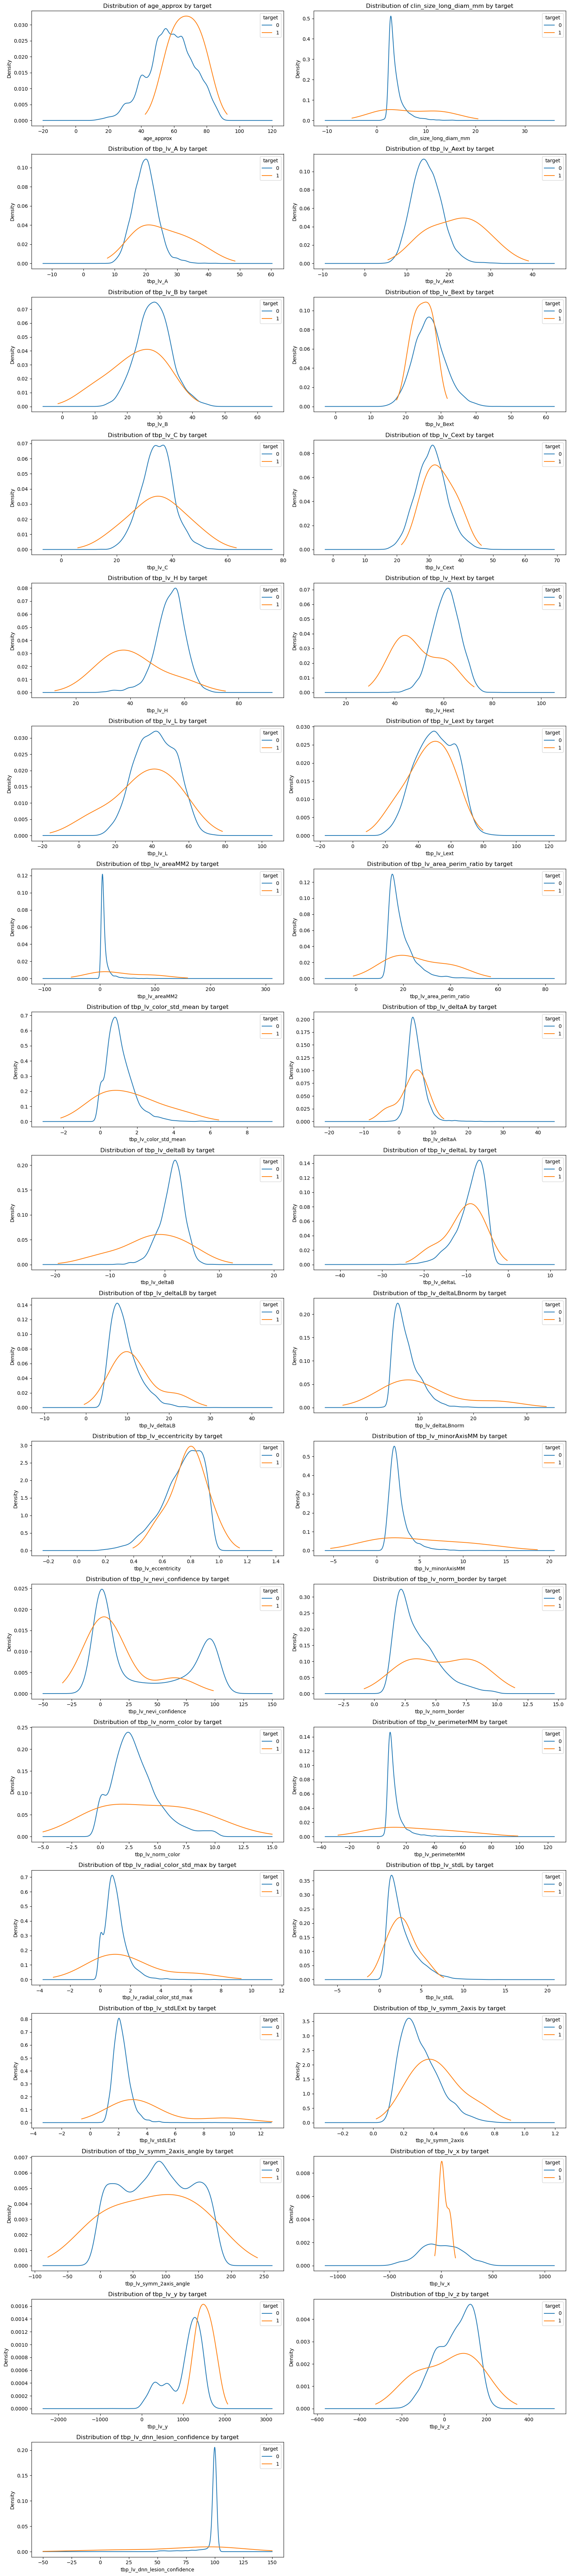

In [9]:
plot_numerical_vs_target(df, 'target', numerical_cols)

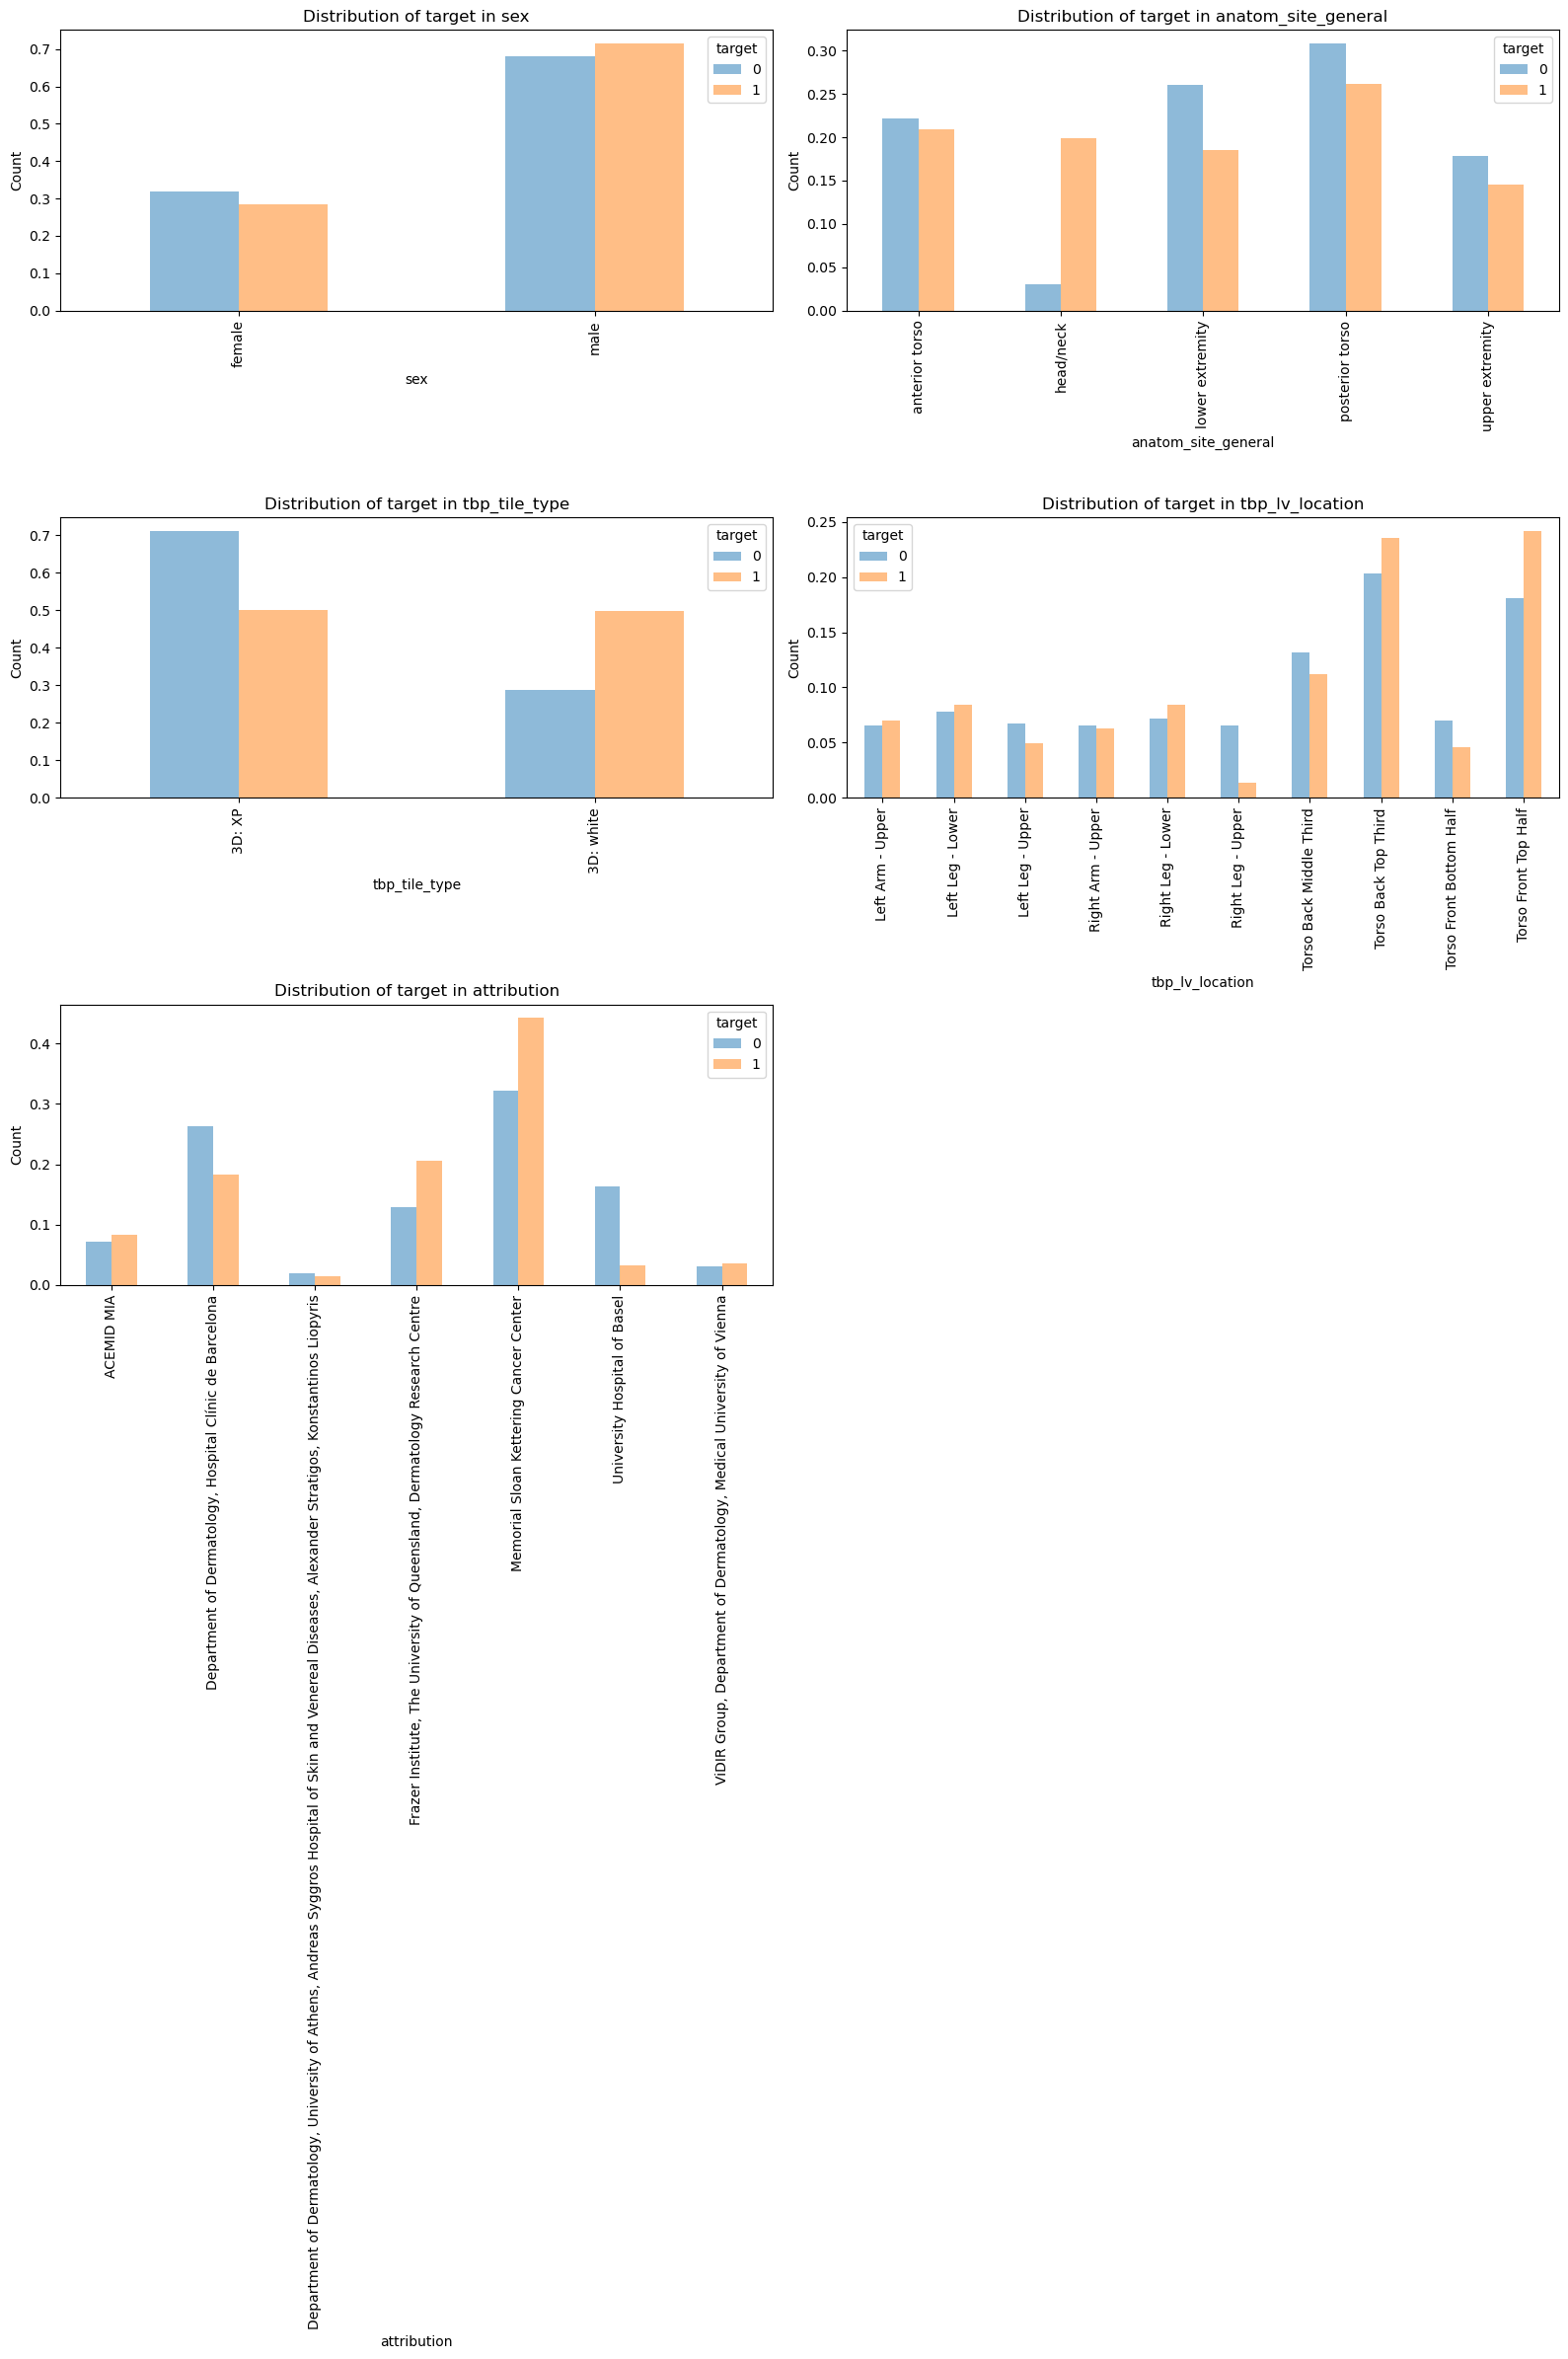

In [10]:
plot_categorical_vs_target(df, 'target', categorical_cols)

In [11]:
class FeatureEngineering:    
    def __init__(self):
        pass
    
    def feature_engineering(self, df):        
        # Malignant v/s Benign Predictive Features from Perplexity Suggestions
        
        df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
        df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"] ** 2)
        df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
        df["luminance_contrast"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()
        df["lesion_color_difference"] = np.sqrt(df["tbp_lv_deltaA"]**2 + df["tbp_lv_deltaB"]**2 + df["tbp_lv_deltaL"]**2)
        df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
        df["3d_position_distance"] = np.sqrt(df["tbp_lv_x"]**2 + df["tbp_lv_y"]**2 + df["tbp_lv_z"]**2)
        df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]
        df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
        df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
        df["color_consistency"] = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]
        df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
        df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
        df["lesion_severity_index"] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df["tbp_lv_eccentricity"]) / 3
        df["color_contrast_index"] = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + df["tbp_lv_deltaLBnorm"]
        df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)
        df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"]
        df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
        df["std_dev_contrast"] = np.sqrt((df["tbp_lv_deltaA"]**2 + df["tbp_lv_deltaB"]**2 + df["tbp_lv_deltaL"]**2) / 3)
        df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + df["tbp_lv_area_perim_ratio"] + df["tbp_lv_symm_2axis"]) / 3
        df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
        df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
        df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] + df["tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4
        
        # Handling error indicators
        df["color_uniformity"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_radial_color_std_max"]
        df["color_uniformity"] = df["color_uniformity"].replace([np.nan, np.inf, -np.inf], 0)
        
        df["combined_anatomical_site"] = (df["anatom_site_general"].astype(str) + "_" + df["tbp_lv_location"].astype(str)).astype("category")
        df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]
        df["3d_lesion_orientation"] = np.arctan2(df["tbp_lv_y"], df["tbp_lv_x"])        
        df["color_variance_ratio"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_stdLExt"]
        df["border_color_interaction"] = df["tbp_lv_norm_border"] * df["tbp_lv_norm_color"]
        df["size_color_contrast_ratio"] = df["clin_size_long_diam_mm"] / df["tbp_lv_deltaLBnorm"]
        df["age_normalized_nevi_confidence"] = df["tbp_lv_nevi_confidence"] / df["age_approx"]
        df["color_asymmetry_index"] = df["tbp_lv_radial_color_std_max"] * df["tbp_lv_symm_2axis"]
        df["3d_volume_approximation"] = df["tbp_lv_areaMM2"] * np.sqrt(df["tbp_lv_x"]**2 + df["tbp_lv_y"]**2 + df["tbp_lv_z"]**2)
        df["color_range"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs() + (df["tbp_lv_A"] - df["tbp_lv_Aext"]).abs() + (df["tbp_lv_B"] - df["tbp_lv_Bext"]).abs()
        df["shape_color_consistency"] = df["tbp_lv_eccentricity"] * df["tbp_lv_color_std_mean"]
        df["border_length_ratio"] = df["tbp_lv_perimeterMM"] / (2 * np.pi * np.sqrt(df["tbp_lv_areaMM2"] / np.pi))
        df["age_size_symmetry_index"] = df["age_approx"] * df["clin_size_long_diam_mm"] * df["tbp_lv_symm_2axis"]
        
        return df
    
    def grouped_feature_engineering(self, df):
        # 1. Ratios within age_approx groups
        df['tbp_lv_ratio_A'] = (
            df['tbp_lv_A'] / (df['tbp_lv_Aext'] * df.groupby('age_approx')['tbp_lv_A'].transform('min'))
        ).astype('float32')

        df['tbp_lv_ratio_B'] = (
            df['tbp_lv_B'] / (df['tbp_lv_Bext'] * df.groupby('age_approx')['tbp_lv_B'].transform('min'))
        ).astype('float32')

        df['tbp_lv_ratio_C'] = (
            df['tbp_lv_C'] / (df['tbp_lv_Cext'] * df.groupby('age_approx')['tbp_lv_C'].transform('min'))
        ).astype('float32')

        df['tbp_lv_ratio_H'] = (
            df['tbp_lv_H'] / (df['tbp_lv_Hext'] * df.groupby('age_approx')['tbp_lv_H'].transform('min'))
        ).astype('float32')

        df['tbp_lv_ratio_L'] = (
            df['tbp_lv_L'] / (df['tbp_lv_Lext'] * df.groupby('age_approx')['tbp_lv_L'].transform('min'))
        ).astype('float32')

        # 2. Contrast
        df['tbp_lv_contrast_A'] = (df['tbp_lv_A'] - df['tbp_lv_Aext']).astype('float32')
        df['tbp_lv_contrast_B'] = (df['tbp_lv_B'] - df['tbp_lv_Bext']).astype('float32')
        df['tbp_lv_contrast_C'] = (df['tbp_lv_C'] - df['tbp_lv_Cext']).astype('float32')
        df['tbp_lv_contrast_H'] = (df['tbp_lv_H'] - df['tbp_lv_Hext']).astype('float32')
        df['tbp_lv_contrast_L'] = (df['tbp_lv_L'] - df['tbp_lv_Lext']).astype('float32')

        # 3. Patient-level ratios
        for col in ['tbp_lv_ratio_A', 'tbp_lv_ratio_B', 'tbp_lv_ratio_C', 'tbp_lv_ratio_H', 'tbp_lv_ratio_L']:
            df[f'tbp_lv_patient_{col.split("_", 2)[-1]}'] = (
                df[col] / df.groupby('patient_id')[col].transform('mean')
            ).astype('float32')

        # 4. Patient-level contrasts
        for col in ['tbp_lv_contrast_A', 'tbp_lv_contrast_B', 'tbp_lv_contrast_C', 'tbp_lv_contrast_H', 'tbp_lv_contrast_L']:
            df[f'tbp_lv_patient_{col.split("_", 2)[-1]}'] = (
                df[col] / df.groupby('patient_id')[col].transform('mean')
            ).astype('float32')

        # 5. Age-level ratios
        for col in ['tbp_lv_ratio_A', 'tbp_lv_ratio_B', 'tbp_lv_ratio_C', 'tbp_lv_ratio_H', 'tbp_lv_ratio_L']:
            df[f'tbp_lv_age_{col.split("_", 2)[-1]}'] = (
                df[col] / df.groupby('age_approx')[col].transform('mean')
            ).astype('float32')

        # 6. Age-level contrasts
        for col in ['tbp_lv_contrast_A', 'tbp_lv_contrast_B', 'tbp_lv_contrast_C', 'tbp_lv_contrast_H', 'tbp_lv_contrast_L']:
            df[f'tbp_lv_age_{col.split("_", 2)[-1]}'] = (
                df[col] / df.groupby('age_approx')[col].transform('mean')
            ).astype('float32')

        return df

    
    def extract_cat_cols(self, df):
        return df.select_dtypes(include=["category"]).columns.tolist()
    
    def remove_null_features(self, df, is_train=True):
        if is_train:
            df = df.dropna(how='any')
        return df

    def process_data(self, df, is_train=True):
        df = self.feature_engineering(df)        
        df = self.grouped_feature_engineering(df) 
        cat_cols = self.extract_cat_cols(df)    

        if is_train:
            df = self.remove_null_features(df, is_train)
        
        return df, cat_cols

In [13]:
fe = FeatureEngineering()
data, cat_cols = fe.process_data(df.copy())

original_cols = set(df.columns)
engineered_cols = [col for col in data.columns if col not in original_cols or col == 'target']

df_engineered = data[engineered_cols]

def print_df_info(df):
    # Count the number of columns by data type
    int_cols = df.select_dtypes(include=['int']).shape[1]
    float_cols = df.select_dtypes(include=['float']).shape[1]
    cat_cols = df.select_dtypes(include=['category']).shape[1]
    obj_cols = df.select_dtypes(include=['object']).shape[1]

    # Calculate the total number of nulls in the DataFrame
    total_nulls = df.isnull().sum().sum()
    shape = df.shape
    
    # Print the results
    print(f"Shape: {shape}")
    print(f"Number of integer columns: {int_cols}")
    print(f"Number of float columns: {float_cols}")
    print(f"Number of categorical columns: {cat_cols}")
    print(f"Number of object columns: {obj_cols}")
    print(f"Total number of nulls in the DataFrame: {total_nulls}")


print("\nFINAL DATASET INFORMATION:")
print_df_info(df_engineered)

# Final categorical columns
print(f"\nFinal categorical columns: \n{cat_cols}")


FINAL DATASET INFORMATION:
Shape: (381914, 68)
Number of integer columns: 0
Number of float columns: 66
Number of categorical columns: 1
Number of object columns: 0
Total number of nulls in the DataFrame: 0

Final categorical columns: 
['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'attribution', 'combined_anatomical_site']


In [14]:
categorical_cols, numerical_cols = extract_columns(df_engineered)

numerical_cols.remove('target')

print(categorical_cols)
print(numerical_cols)

['combined_anatomical_site']
['lesion_size_ratio', 'lesion_shape_index', 'hue_contrast', 'luminance_contrast', 'lesion_color_difference', 'border_complexity', '3d_position_distance', 'perimeter_to_area_ratio', 'lesion_visibility_score', 'symmetry_border_consistency', 'color_consistency', 'size_age_interaction', 'hue_color_std_interaction', 'lesion_severity_index', 'color_contrast_index', 'log_lesion_area', 'normalized_lesion_size', 'mean_hue_difference', 'std_dev_contrast', 'color_shape_composite_index', 'overall_color_difference', 'symmetry_perimeter_interaction', 'comprehensive_lesion_index', 'color_uniformity', 'shape_complexity_index', '3d_lesion_orientation', 'color_variance_ratio', 'border_color_interaction', 'size_color_contrast_ratio', 'age_normalized_nevi_confidence', 'color_asymmetry_index', '3d_volume_approximation', 'color_range', 'shape_color_consistency', 'border_length_ratio', 'age_size_symmetry_index', 'tbp_lv_ratio_A', 'tbp_lv_ratio_B', 'tbp_lv_ratio_C', 'tbp_lv_ratio_

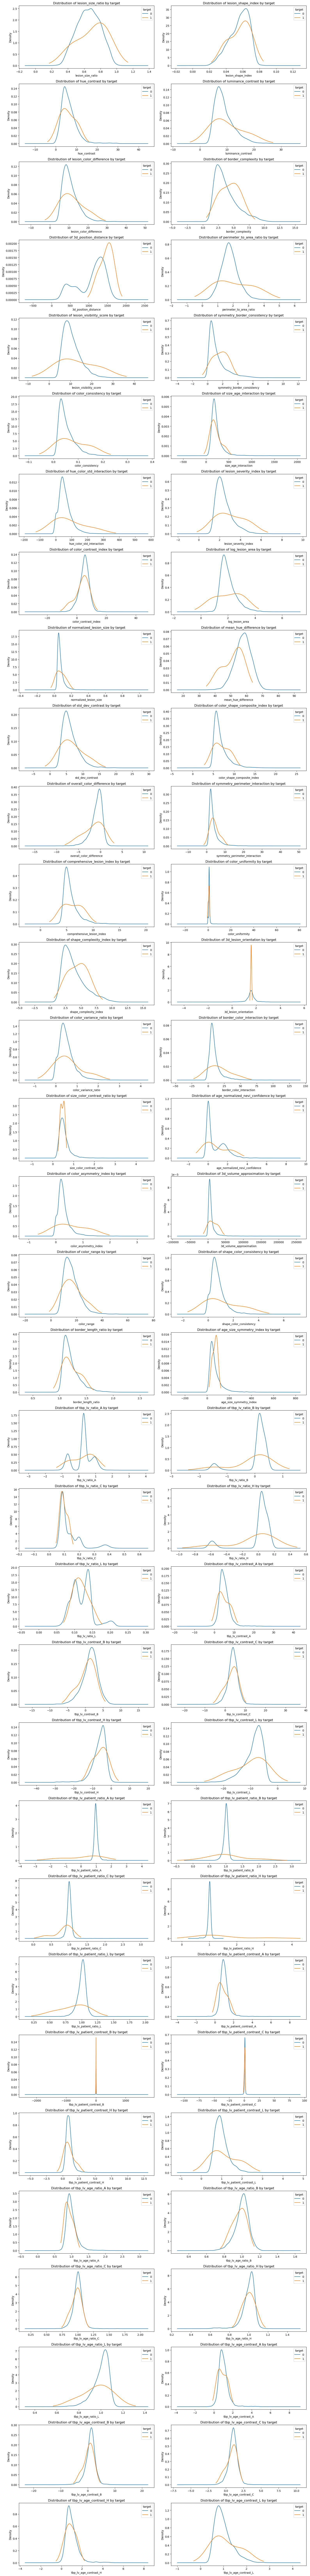

In [15]:
plot_numerical_vs_target(df_engineered, 'target', numerical_cols)

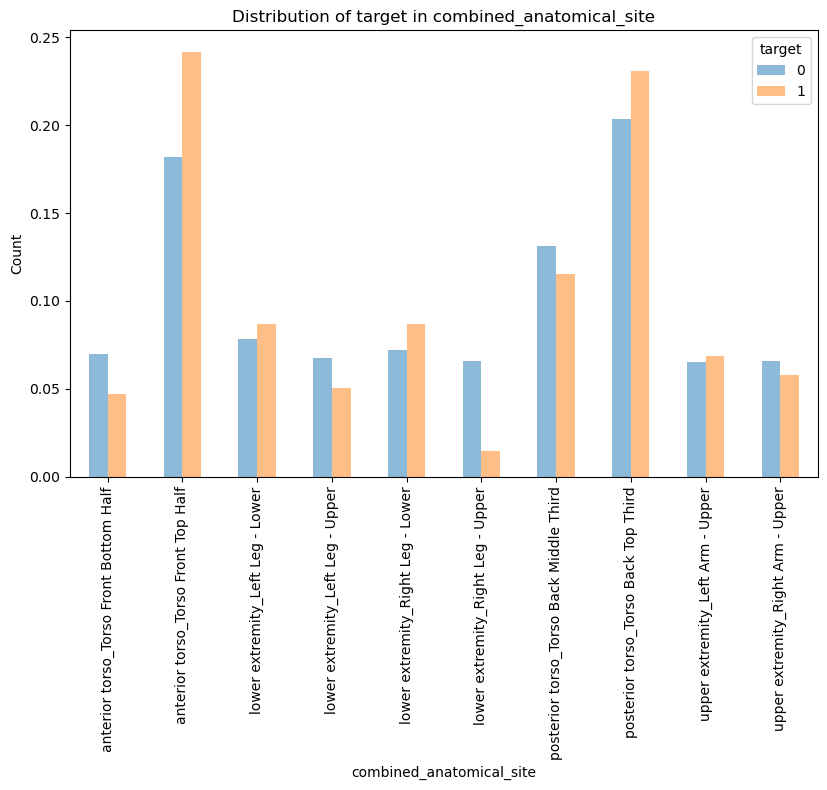

In [16]:
plot_categorical_vs_target(df_engineered, 'target', categorical_cols)

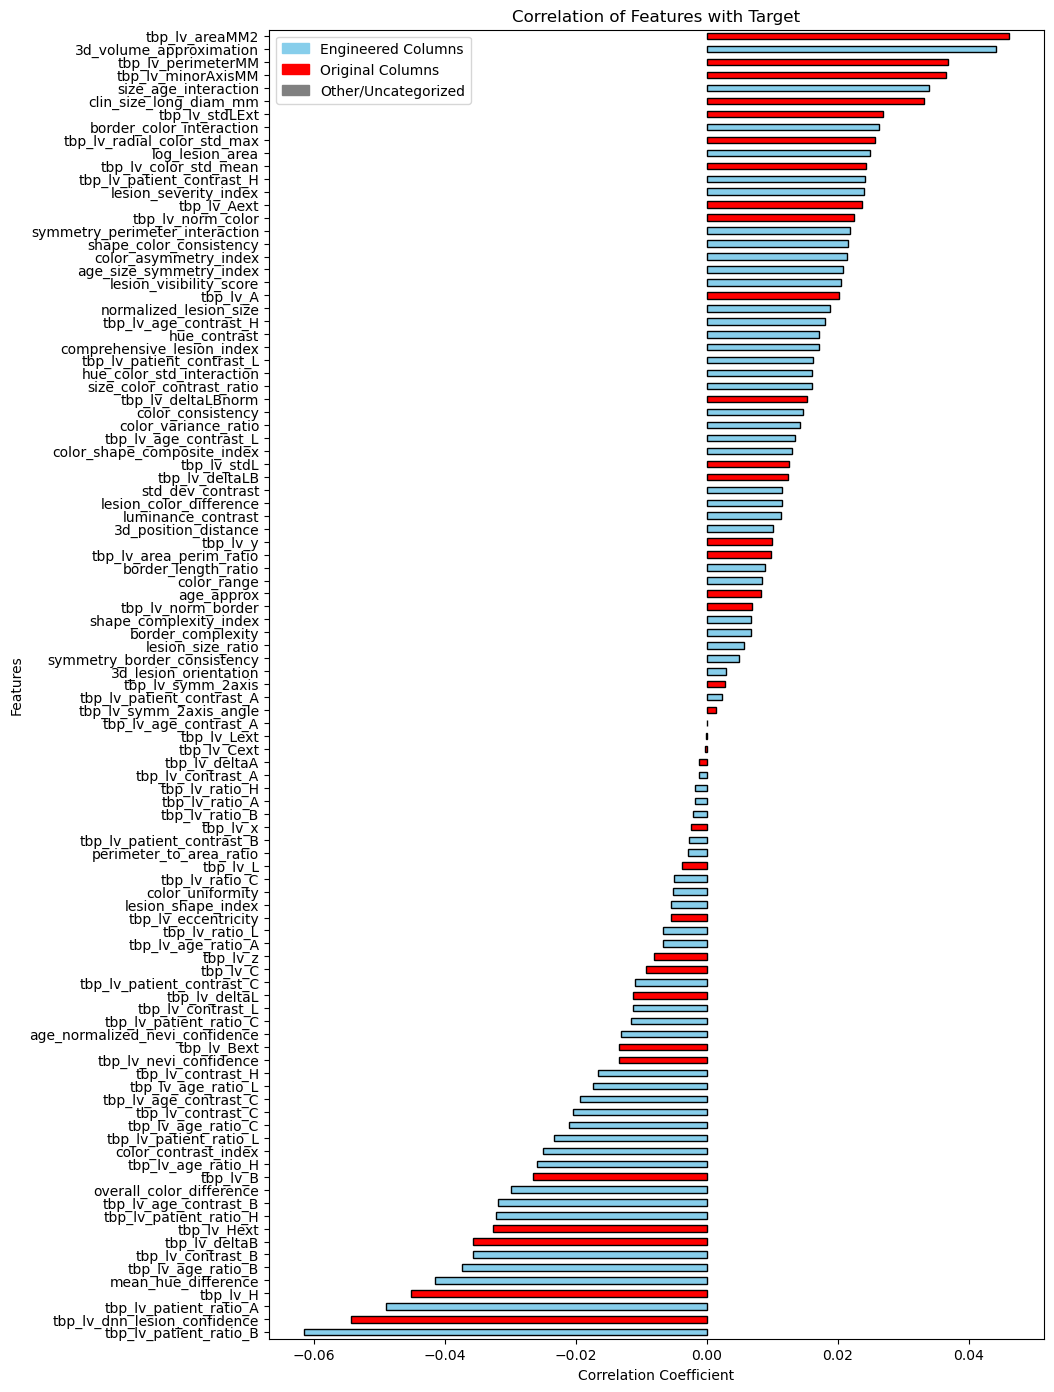

In [28]:
import matplotlib.patches as mpatches
# Compute correlations with target
correlations = data.corr(numeric_only=True)['target'].drop('target').sort_values()

# Assign colors based on membership
colors = [
    "skyblue" if col in engineered_cols else 
    "red" if col in original_cols else 
    "gray"  # fallback if column not listed
    for col in correlations.index
]

# Plot
plt.figure(figsize=(10,17))
correlations.plot(kind='barh', color=colors, edgecolor="black")
plt.title("Correlation of Features with Target")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")

legend_patches = [
    mpatches.Patch(color="skyblue", label="Engineered Columns"),
    mpatches.Patch(color="red", label="Original Columns"),
    mpatches.Patch(color="gray", label="Other/Uncategorized")  # optional
]
plt.legend(handles=legend_patches, loc="best")
plt.show()

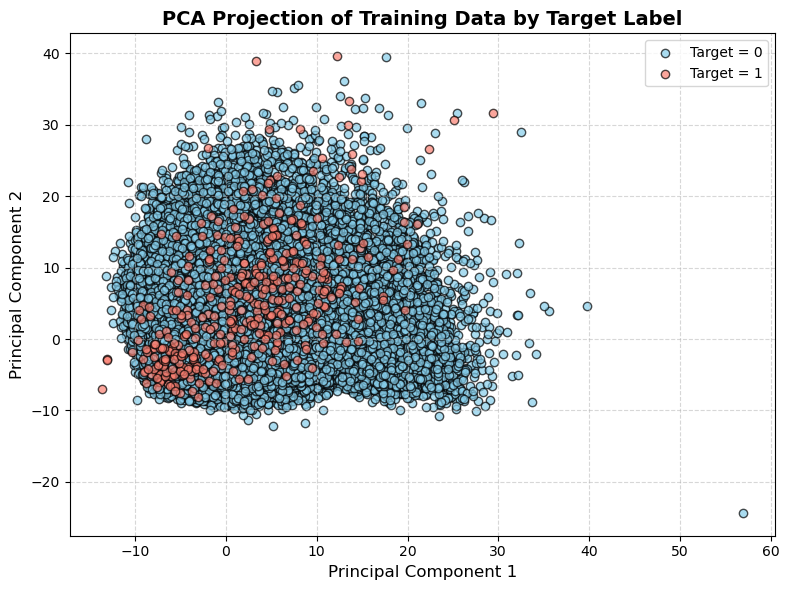

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import mode
import seaborn as sns

# ---------- DATA PREP ----------
# Separate features and target
X = data.drop(columns=['target']).select_dtypes(['number'])
y = data['target']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------- PCA ----------
pca = PCA(n_components=0.95)  # Keep 95% variance
X_pca = pca.fit_transform(X_scaled)

# ---------- KMEANS ----------
kmeans = KMeans(n_clusters=2, random_state=42)
train_clusters = kmeans.fit_predict(X_pca)

# ---------- CLEAR PCA PLOT FOR TARGET LABELS ----------
plt.figure(figsize=(8, 6))

# Scatter for label 0
plt.scatter(
    X_pca[y == 0, 0],
    X_pca[y == 0, 1],
    color='skyblue',
    alpha=0.7,
    edgecolors='k',
    label='Target = 0'
)

# Scatter for label 1
plt.scatter(
    X_pca[y == 1, 0],
    X_pca[y == 1, 1],
    color='salmon',
    alpha=0.7,
    edgecolors='k',
    label='Target = 1'
)

plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.title("PCA Projection of Training Data by Target Label", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

